In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gnn-political-books/polbooks.gml


References:
- [Stanford CS224W](https://youtube.com/playlist?list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&si=dECLC5c4u7kPfPq-)
- [Graph Representation Learning - William Hamilton](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf)
- [Hands-On Graph Neural Networks Using Python - Maxime Labonne](https://github.com/PacktPublishing/Hands-On-Graph-Neural-Networks-Using-Python)
- [Graph Neural Networks in Action - Keita Broadwater](https://www.manning.com/books/graph-neural-networks-in-action)

# Graph Embeddings

In this notebook, we will learn about how to generate embeddings using the following:
- Word2Vec $\rightarrow$ word embeddings
- DeepWalk $\rightarrow$ node embeddings
- Node2Vec $\rightarrow$ node embeddings
- Graph Neural Network $\rightarrow$ node embeddings

We will use a dataset in `.gml` format (graph modeling language) that contains information about political books:
- Nodes $\rightarrow$ Represent books about US politics sold by Amazon.
- Edges $\rightarrow$ Indicate frequent co-purchasing by the same buyers, as suggested by Amazon's recommendation feature: "customers who bought this book also bought these other books".

In [2]:
!pip install torch_geometric
!pip install node2vec
!pip install umap-learn 

print("required libraries installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 40.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scik

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.datasets import Planetoid, FacebookPagePage
import torch_geometric.transforms as pyg_T
import torch_geometric.utils as pyg_utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
import os
from tqdm import tqdm
import networkx as nx
import gc
from collections import Counter

from node2vec import Node2Vec
from sklearn.manifold import TSNE
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss

print("imports done!")

2025-07-06 09:37:28.169603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751794648.430288      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751794648.507251      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


imports done!


In [4]:
print("torch_geometric version:", torch_geometric.__version__)
print("torch version:", torch.__version__)

torch_geometric version: 2.6.1
torch version: 2.6.0+cu124


### Let's draw a graph

/usr/local/lib/python3.11/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


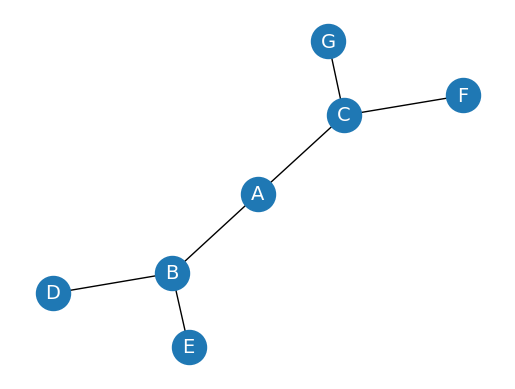

In [5]:
G = nx.Graph()
G.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'D'),
('B', 'E'), ('C', 'F'), ('C', 'G')])
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [6]:
os.listdir("../input/gnn-political-books/")

['polbooks.gml']

## Word2Vec

## DeepWalk

## Node2Vec

In [7]:
# Load the GML file
gml_graph = nx.read_gml('../input/gnn-political-books/polbooks.gml')

print("Total no. of nodes:", len(gml_graph.nodes))
print("Total no. of edges:", len(gml_graph.edges))
# print(gml_graph.nodes(data=True))  # Print nodes with their attributes
# print(gml_graph.edges(data=True))  # Print edges with their attributes

Total no. of nodes: 105
Total no. of edges: 441


In [8]:
# Initialize a dictionary to store counts
value_counts = {}

# Iterate through the list of tuples
for _, attributes in gml_graph.nodes(data=True):
    value = attributes['value']
    if value in value_counts:
        value_counts[value] += 1
    else:
        value_counts[value] = 1

# Print the counts for each 'value'
# print(value_counts)
total_nodes = sum(value_counts.values())
print(f"No. of nodes representing liberal books:\t {round(value_counts['l']/total_nodes, 3)*100}%")
print(f"No. of nodes representing conservative books:\t {round(value_counts['c']/total_nodes, 3)*100}%")
print(f"No. of nodes representing neutral books:\t {round(value_counts['n']/total_nodes, 3)*100}%")

No. of nodes representing liberal books:	 41.0%
No. of nodes representing conservative books:	 46.7%
No. of nodes representing neutral books:	 12.4%


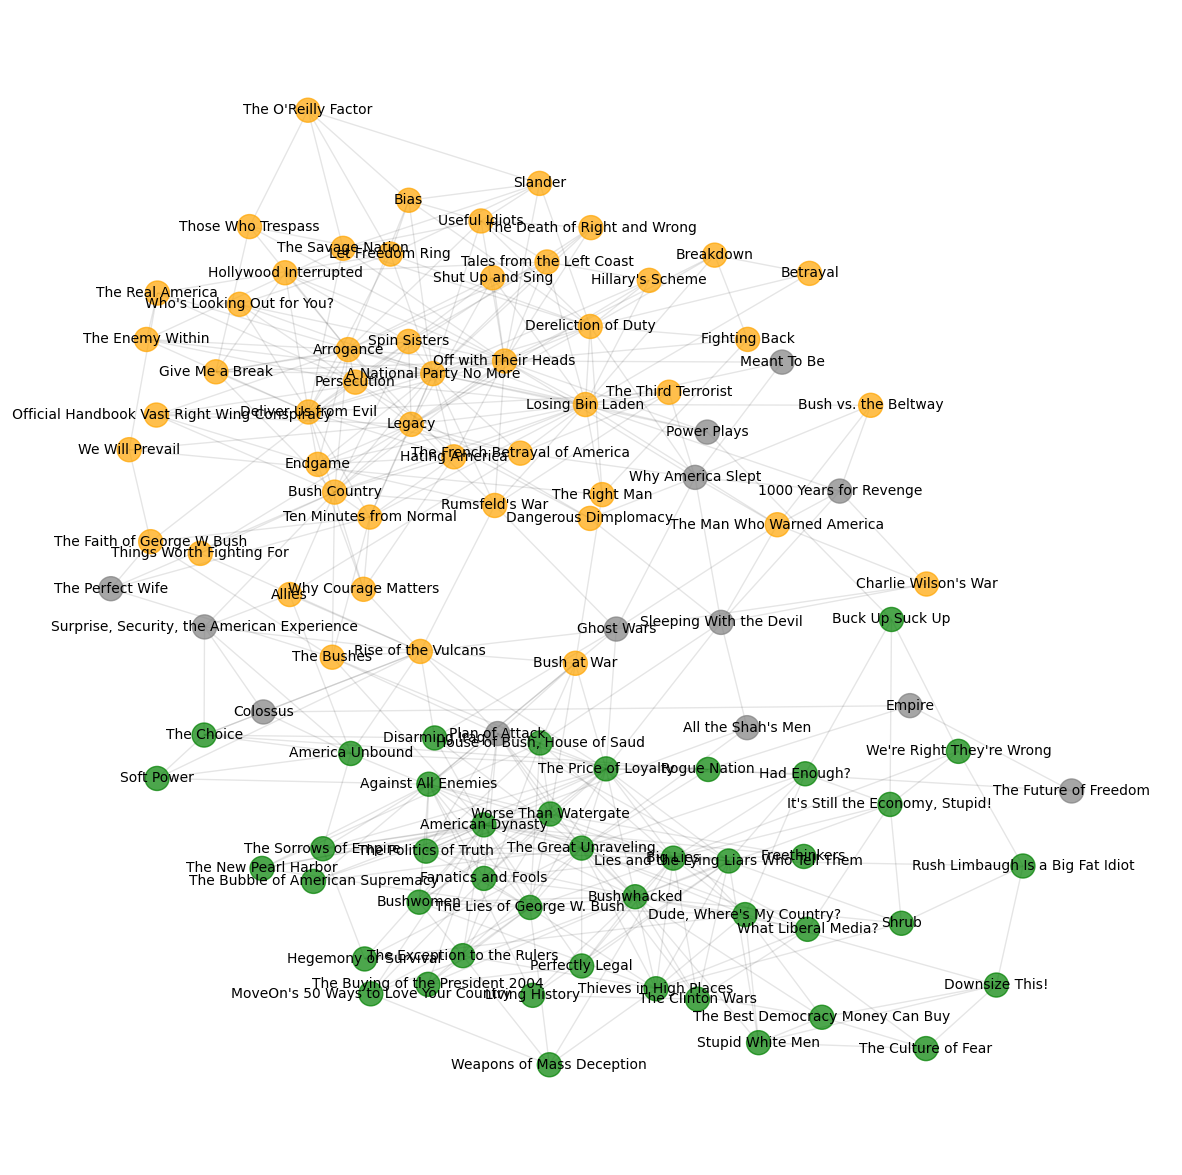

In [9]:
# Increase figure size
plt.figure(figsize=(15, 15))

# Change layout
pos = nx.kamada_kawai_layout(gml_graph)

# Adjust node size (optional, if you have a measure like degree to scale by)
# node_sizes = [gml_graph.degree[node] * 100 for node in gml_graph.nodes()]

# Adjust font size
font_sizes = 10  # or any other size

# Define your color mapping
color_map = {'l': 'green', 'c': 'orange', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Draw nodes
nx.draw_networkx_nodes(gml_graph, pos, node_color=node_colors, alpha=0.7)

# Draw edges with transparency
nx.draw_networkx_edges(gml_graph, pos, alpha=0.1)

# Draw labels with font size
nx.draw_networkx_labels(gml_graph, pos, font_size=font_sizes)

# Remove the axes
plt.axis('off')

# Show the plot
plt.show()

In [10]:
# Initialize the node2vec model and train it
node2vec = Node2Vec(gml_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract node embeddings into a dictionary
embeddings = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 25.20it/s]


In [11]:
# Transform the embeddings into a list of vectors for a dimensionality reduction algorithm like t-SNE or UMAP
node_embeddings = [embeddings[str(node)] for node in gml_graph.nodes()]
node_embeddings_array = np.array(node_embeddings)

In [12]:
print(model.wv["The Enemy Within"])   # node embedding for the book "The Enemy Within"

[-0.07070494  0.20525964  0.21745417 -0.2568258  -0.08584301 -0.14276627
 -0.28923473 -0.22333036 -0.15916762  0.05974757  0.22497243 -0.11935124
  0.16414808 -0.191421   -0.23653702 -0.3771363   0.00995428  0.21993656
  0.13049036  0.07129823 -0.13349748 -0.40894762  0.3106627  -0.17413272
 -0.2589206  -0.00414715 -0.16467111 -0.06878888  0.544068    0.17846893
 -0.2631347   0.5123734   0.07962008 -0.32619664  0.13289598 -0.13702728
  0.1152008   0.03438046  0.2772696   0.22935456  0.14386341  0.18047124
 -0.74500304  0.36322412  0.21798286  0.09731956 -0.20021147 -0.01226548
 -0.11578944  0.24793966 -0.09441711 -0.18116562  0.34092918  0.06382076
 -0.1994245   0.58848405 -0.28775597 -0.09127007 -0.01037406  0.0918346
 -0.07754183  0.28807372 -0.0697172  -0.21031293]


#### Using t-SNE for reducing the embedding to 2 dimensions

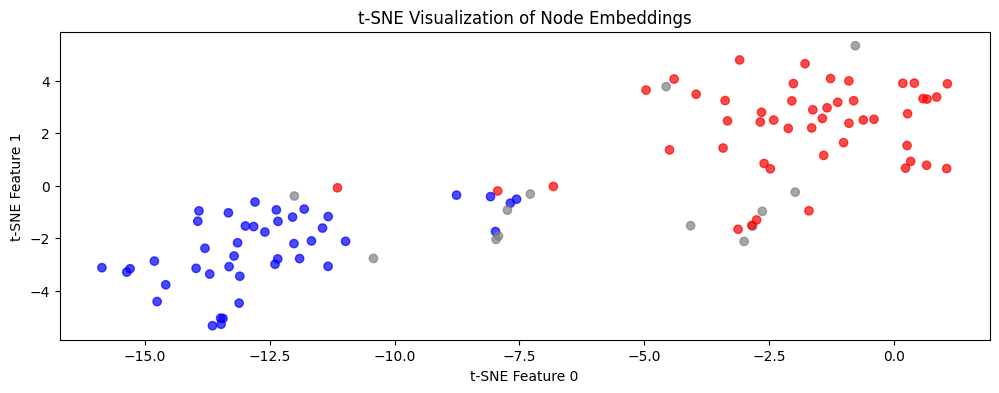

In [13]:
# Prepare a color map and the colors for each node (for t-SNE)
color_map = {'l': 'blue', 'c': 'red', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Initialize and fit t-SNE
tsne_model = TSNE(n_components=2, learning_rate='auto', init='random')
tsne_features = tsne_model.fit_transform(node_embeddings_array)

# Plot the nodes with t-SNE embeddings and color by their 'value'
plt.figure(figsize=(12, 4))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], color=node_colors, alpha=0.7)

# Optionally, add labels for each point
#for i, node in enumerate(gml_graph.nodes()):
#    plt.annotate(node, (tsne_features[i, 0], tsne_features[i, 1]))

plt.xlabel('t-SNE Feature 0')
plt.ylabel('t-SNE Feature 1')
plt.title('t-SNE Visualization of Node Embeddings')
plt.show()

#### Using UMAP for reducing the embedding to 2 dimensions

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


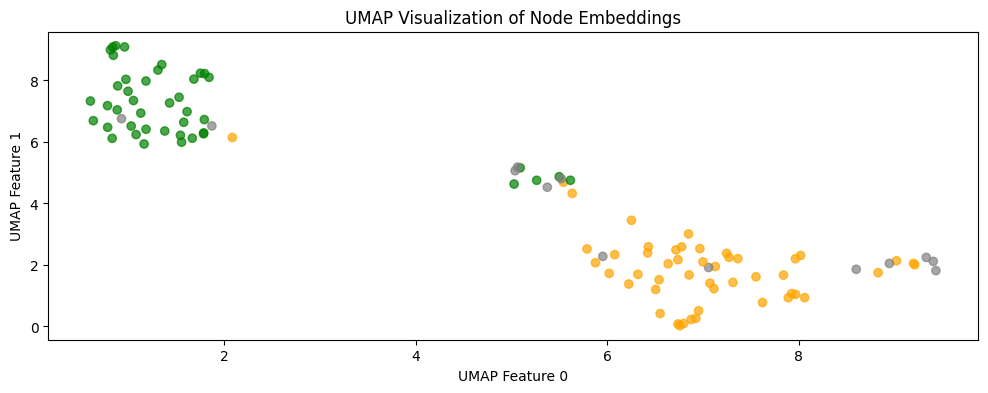

In [14]:
# Prepare a different color map and the colors for each node (for UMAP)
color_map = {'l': 'green', 'c': 'orange', 'n': 'grey'}
node_colors = [color_map[gml_graph.nodes[node]['value']] for node in gml_graph.nodes()]

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(node_embeddings_array)

# Plot the nodes with UMAP embeddings and color by their 'value'
plt.figure(figsize=(12, 4))
plt.scatter(umap_features[:, 0], umap_features[:, 1], color=node_colors, alpha=0.7)

# Optionally, add labels for each point
#for i, node in enumerate(gml_graph.nodes()):
#    plt.annotate(node, (umap_features[i, 0], umap_features[i, 1]))

plt.xlabel('UMAP Feature 0')
plt.ylabel('UMAP Feature 1')
plt.title('UMAP Visualization of Node Embeddings')
plt.show()

#### Directly generating 2-dimensional node embeddings from Node2Vec

Computing transition probabilities:   0%|          | 0/105 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 34.94it/s]


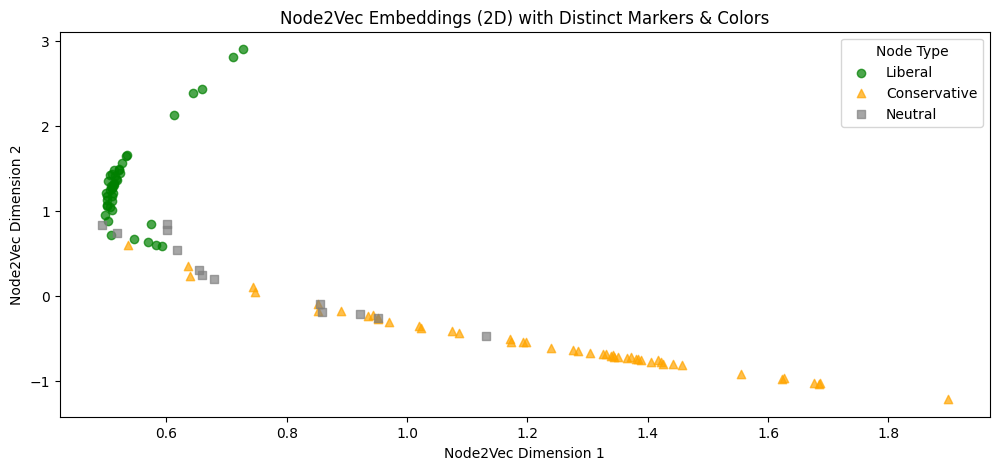

In [15]:
# Set dimensions=2 for direct 2D plotting
node2vec = Node2Vec(gml_graph, dimensions=2, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract 2D embeddings into a dictionary
embeddings_2d = {str(node): model.wv[str(node)] for node in gml_graph.nodes()}

# Prepare a color map
color_map = {
    'l': 'green',
    'c': 'orange',
    'n': 'grey'
}

# Prepare a shape map
shape_map = {
    'l': 'o',  # Circle
    'c': '^',  # Triangle
    'n': 's'   # Square
}

# Map each class letter to a full legend label
legend_labels = {
    'l': 'Liberal',
    'c': 'Conservative',
    'n': 'Neutral'
}

# Create a list of nodes to maintain a fixed order
node_list = list(gml_graph.nodes())

# Convert the embeddings to a NumPy array (in the same order as node_list)
points = np.array([embeddings_2d[node] for node in node_list])

# --- Plotting Section ---
plt.figure(figsize=(12, 5))

# Plot each class separately with its own color and marker
for class_value in color_map.keys():
    # Indices of nodes belonging to this class
    class_indices = [
        i for i, node in enumerate(node_list)
        if gml_graph.nodes[node]['value'] == class_value
    ]
    
    # Scatter plot for this class
    plt.scatter(
        points[class_indices, 0],  # x-coordinates
        points[class_indices, 1],  # y-coordinates
        color=color_map[class_value],
        marker=shape_map[class_value],
        alpha=0.7,
        label=legend_labels[class_value]
    )

# Optionally label specific nodes
# for i, node in enumerate(node_list):
#     plt.annotate(node, (points[i, 0], points[i, 1]), fontsize=9)

# Create a legend from the scatter calls above
plt.legend(title='Node Type')

# Axes labels and title
plt.xlabel('Node2Vec Dimension 1')
plt.ylabel('Node2Vec Dimension 2')
plt.title('Node2Vec Embeddings (2D) with Distinct Markers & Colors')
plt.show()

In [16]:
gc.collect()
print("freed up some memory")

freed up some memory


Quoting from [Graph Neural Networks in Action - Keita Broadwater](https://www.manning.com/books/graph-neural-networks-in-action):

>  It's important to understand the nature of Node2Vec's learning approach, which is *transductive*. Transductive learning is designed to work only with the specific dataset it was trained on and can't generalize to new, unseen nodes without retraining the model. This characteristic makes N2V highly effective for static datasets where all nodes and edges are known up front but less suitable for dynamic settings where new data points or connections frequently appear. Essentially, N2V focuses on extracting detailed patterns and relationships from the existing graph rather than developing a model that can easily adapt to new data.

>  While this transductive nature has its limitations, it also offers significant advantages. Because N2V uses the full structure of the graph during training, it can capture intricate relationships and dependencies that might be missed by more generalized methods. This makes N2V particularly powerful for tasks where the complete, fixed structure of the data is known and stable. However, to apply N2V effectively, it's crucial to ensure that the graph data is represented in a way that captures all relevant features. In some cases, additional edges or nodes may need to be added to the graph to fully represent the underlying relationships.

> Unlike N2V, which is a transductive method limited to the specific nodes and edges in the training data, GNNs can learn in an *inductive* manner. This means GNNs are capable of generalizing to new, unseen nodes or edges without requiring retraining on the entire graph.

>  GNNs achieve this by not only understanding the network's complex structure but also by incorporating node features and relationships into the learning process. This approach allows GNNs to adapt dynamically to changes in the graph, making them well-suited for applications where the data is continually evolving. The shift from N2V to GNNs represents a key transition from focusing on deep analysis within a static dataset to a broader applicability across diverse, evolving networks. 

## Graph Neural Networks (GNNs)

In [17]:
class SimpleGNN(nn.Module):
    def __init__(self, num_features, hidden_dim, embed_dim):
        super(SimpleGNN, self).__init__()
        self.conv1 = pyg_nn.GCNConv(num_features, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, embed_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)
        

In [49]:
# Convert NetworkX graph to a PyTorch Geometric Data object
data = pyg_utils.convert.from_networkx(gml_graph)

# Initialize node features with Xavier initialization
num_features = 64
data.x = torch.empty((data.num_nodes, num_features), dtype=torch.float)  # Create an empty tensor
nn.init.xavier_uniform_(data.x)  # Apply Xavier initialization

model = SimpleGNN(num_features=data.x.shape[1], hidden_dim=64, embed_dim=64)

model.eval()
with torch.no_grad():
    gnn_embeddings = model(data.x, data.edge_index)


In [19]:
gnn_embeddings

(tensor([[ 0.0221, -0.0044, -0.0056,  ...,  0.0413,  0.0008, -0.0253],
         [ 0.0210, -0.0113, -0.0010,  ...,  0.0265, -0.0031, -0.0078],
         [ 0.0152,  0.0018, -0.0060,  ...,  0.0396,  0.0071, -0.0380],
         ...,
         [-0.0120, -0.0081,  0.0236,  ...,  0.0361,  0.0069, -0.0062],
         [-0.0188, -0.0064, -0.0015,  ...,  0.0582, -0.0312, -0.0218],
         [-0.0292, -0.0052,  0.0051,  ...,  0.0512, -0.0268, -0.0236]]),
 tensor([[-4.1387, -4.1652, -4.1664,  ..., -4.1195, -4.1600, -4.1861],
         [-4.1394, -4.1717, -4.1613,  ..., -4.1338, -4.1634, -4.1682],
         [-4.1459, -4.1593, -4.1671,  ..., -4.1215, -4.1540, -4.1991],
         ...,
         [-4.1687, -4.1648, -4.1331,  ..., -4.1206, -4.1498, -4.1629],
         [-4.1794, -4.1671, -4.1621,  ..., -4.1024, -4.1918, -4.1824],
         [-4.1893, -4.1654, -4.1551,  ..., -4.1089, -4.1869, -4.1837]]))

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_35/1120462870.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_features[:, 0], umap_features[:, 1], c=node_colors, cmap='viridis', s=15)


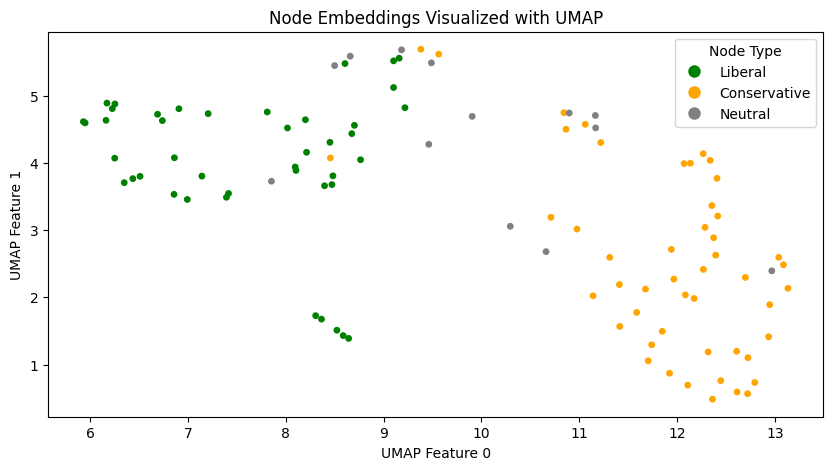

In [54]:
# Convert to numpy for UMAP
gnn_embeddings_np = gnn_embeddings[0].detach().cpu().numpy()

# Initialize and fit UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_features = umap_model.fit_transform(gnn_embeddings_np)

plt.figure(figsize=(10, 5))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=node_colors, cmap='viridis', s=15)
plt.title('Node Embeddings Visualized with UMAP')
plt.xlabel('UMAP Feature 0')
plt.ylabel('UMAP Feature 1')

legend_labels = {
    'l': 'Liberal',
    'c': 'Conservative',
    'n': 'Neutral'
}

handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[key], 
                      markerfacecolor=color_map[key], markersize=10) for key in legend_labels]
plt.legend(handles=handles, title='Node Type')
plt.show()

#### Semi-supervised learning

First, we extract labels from the nodes. To set up the semi-supervised learning problem, we randomly hide the labels from some nodes. To achieve this, we make use of labelled and unlabelled masks.

Then we train models using labelled data, and make predictions on the unlabelled data.

In [56]:
# Extract labels and handle neutral values
labels = []
for node, value in gml_graph.nodes(data=True):
    if value['value'] == 'c':
        labels.append('right')
    elif value['value'] == 'l':
        labels.append('left')
    else:  # Handle neutral and missing values
        labels.append('neutral')

labels = np.array(labels)

random.seed(52)

# Indices of all nodes
indices = list(range(len(labels)))

# Percentage of data to keep as labelled
labelled_percentage = 0.2

# Select a subset of indices to remain labelled
labelled_indices = random.sample(indices, int(labelled_percentage * len(labels)))

# Initialize masks for labelled and unlabelled data
labelled_mask = np.zeros(len(labels), dtype=bool)
unlabelled_mask = np.ones(len(labels), dtype=bool)

# Update masks
labelled_mask[labelled_indices] = True
unlabelled_mask[labelled_indices] = False

# Use masks to split the dataset
labelled_labels = labels[labelled_mask]
unlabelled_labels = labels[unlabelled_mask]  # these labels won't be used during training

label_mapping = {'left': 0, 'right': 1, 'neutral': 2}
numeric_labels = np.array([label_mapping[label] for label in labels])

In [58]:
numeric_labels

array([2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2])

In [59]:
print("labelled_masks:\n", labelled_mask, sep='')
print("\n\nunlabelled_masks:\n", unlabelled_mask, sep='')

labelled_masks:
[ True  True False False  True False  True False  True False False False
 False False False False False  True False False  True False False  True
 False False False False False False  True False False False  True False
 False False False False False False False False  True False False  True
 False  True False False  True False False False  True False False False
 False  True False False False  True False False False  True False False
 False False False False False False False False  True False False False
 False False False False False False False False  True False False False
 False False False False False False  True False False]


unlabelled_masks:
[False False  True  True False  True False  True False  True  True  True
  True  True  True  True  True False  True  True False  True  True False
  True  True  True  True  True  True False  True  True  True False  True
  True  True  True  True  True  True  True  True False  True  True False
  True False  True  True False  

In [60]:
print("labelled_labels:\n", labelled_labels, sep='')
print("\n\nunlabelled_labels:\n", unlabelled_labels, sep='')

labelled_labels:
['neutral' 'right' 'neutral' 'neutral' 'right' 'right' 'right' 'right'
 'left' 'right' 'right' 'right' 'right' 'right' 'right' 'left' 'left'
 'neutral' 'left' 'left' 'left']


unlabelled_labels:
['right' 'right' 'right' 'neutral' 'right' 'right' 'right' 'right' 'right'
 'right' 'right' 'right' 'neutral' 'right' 'right' 'right' 'right' 'right'
 'right' 'right' 'neutral' 'right' 'left' 'right' 'right' 'right' 'right'
 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'neutral'
 'neutral' 'right' 'neutral' 'right' 'right' 'right' 'right' 'right'
 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
 'left' 'left' 'left' 'left' 'neutral' 'right' 'left' 'left' 'left' 'left'
 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'neutral'
 'neutral']


In [61]:
# For GNN embeddings
X_train_gnn, y_train_gnn = gnn_embeddings[0][labelled_mask], numeric_labels[labelled_mask]

# For N2V embeddings
# Ensure node2vec embeddings are in the same order as labels
X_n2v = np.array([embeddings[str(node)] for node in gml_graph.nodes()])
X_train_n2v, y_train_n2v = X_n2v[labelled_mask], numeric_labels[labelled_mask]

In [62]:
# Classifier for GNN embeddings
clf_gnn = RandomForestClassifier()
clf_gnn.fit(X_train_gnn, y_train_gnn)

# Classifier for N2V embeddings
clf_n2v = RandomForestClassifier()
clf_n2v.fit(X_train_n2v, y_train_n2v)

RandomForestClassifier()

In [63]:
# Predictions with GNN embeddings
y_pred_gnn = clf_gnn.predict(gnn_embeddings[0][unlabelled_mask])
# Evaluate GNN classifier
gnn_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_gnn)
gnn_f1_score = f1_score(numeric_labels[unlabelled_mask], y_pred_gnn, average='weighted')

# Predictions with N2V embeddings
y_pred_n2v = clf_n2v.predict(X_n2v[unlabelled_mask])
# Evaluate N2V classifier
n2v_accuracy = accuracy_score(numeric_labels[unlabelled_mask], y_pred_n2v)
n2v_f1_score = f1_score(numeric_labels[unlabelled_mask], y_pred_n2v, average='weighted')

print(f"GNN Accuracy: {gnn_accuracy:.4f}")
print(f"GNN F1 Score: {gnn_f1_score:.4f}")
print(f"N2V Accuracy: {n2v_accuracy:.4f}")
print(f"N2V F1 Score: {n2v_f1_score:.4f}")

GNN Accuracy: 0.7738
GNN F1 Score: 0.7702
N2V Accuracy: 0.8571
N2V F1 Score: 0.8134


#### Using a GNN with embeddings for label prediction

In [64]:
class SimpleGNN2(nn.Module):
    def __init__(self, num_features, hidden_dim, embed_dim):
        super(SimpleGNN2, self).__init__()
        self.conv1 = pyg_nn.GCNConv(num_features, hidden_dim)
        self.conv2 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = pyg_nn.GCNConv(hidden_dim, hidden_dim)
        self.conv4 = pyg_nn.GCNConv(hidden_dim, embed_dim)

    def forward(self, x, edge_index):
        x = F.dropout(F.relu(self.conv1(x, edge_index)), training=self.training)
        x = F.dropout(F.relu(self.conv2(x, edge_index)), training=self.training)
        x = F.dropout(F.relu(self.conv3(x, edge_index)), training=self.training)
        x = self.conv4(x, edge_index)
        return x, F.log_softmax(x, dim=1)
        

In [65]:
model1 = SimpleGNN(num_features=data.x.shape[1], hidden_dim=64, embed_dim=64)
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

model2 = SimpleGNN2(num_features=data.x.shape[1], hidden_dim=64, embed_dim=64)
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

# Use nn.CrossEntropyLoss when the model's prediction are logits.
# Use nn.NLLLoss() when the model's predictions are log probabilities, ie, F.log_softmax().
loss_fn = nn.NLLLoss()   # multi-class classification

In [66]:
# Extract labels and handle neutral values
labels = []
for node, value in gml_graph.nodes(data=True):
    if value['value'] == 'c':
        labels.append('right')
    elif value['value'] == 'l':
        labels.append('left')
    else:  # Handle neutral and missing values
        labels.append('neutral')

labels = np.array(labels)

random.seed(42)

# Indices of all nodes
indices = list(range(len(labels)))

# Percentage of data to keep as labelled
labelled_percentage = 0.8

# Select a subset of indices to remain labelled
labelled_indices = random.sample(indices, int(labelled_percentage * len(labels)))

# Initialize masks for labelled and unlabelled data
labelled_mask = np.zeros(len(labels), dtype=bool)
unlabelled_mask = np.ones(len(labels), dtype=bool)

# Update masks
labelled_mask[labelled_indices] = True
unlabelled_mask[labelled_indices] = False

# Use masks to split the dataset
labelled_labels = labels[labelled_mask]
unlabelled_labels = labels[unlabelled_mask]  # these labels won't be used during training

label_mapping = {'left': 0, 'right': 1, 'neutral': 2}
numeric_labels = np.array([label_mapping[label] for label in labels])

In [67]:
# Convert NetworkX graph to a PyTorch Geometric Data object
data = pyg_utils.convert.from_networkx(gml_graph)

# Initialize node features with Xavier initialization
num_features = 64
data.x = torch.empty((data.num_nodes, num_features), dtype=torch.float)  # Create an empty tensor
nn.init.xavier_uniform_(data.x)  # Apply Xavier initialization

train_labels = torch.tensor(numeric_labels, dtype=torch.long)[labelled_mask]
test_labels = torch.tensor(numeric_labels, dtype=torch.long)[unlabelled_mask]

# Assuming 'labelled_mask' is a boolean array indicating which nodes are labelled
data.train_mask = torch.tensor(labelled_mask, dtype=torch.bool)
# Assuming 'unlabelled_mask' is a boolean array indicating which nodes are labelled
data.test_mask = torch.tensor(unlabelled_mask, dtype=torch.bool)

In [68]:
data.x

tensor([[ 0.0284,  0.1348, -0.0314,  ..., -0.0135,  0.0414, -0.0595],
        [ 0.0360,  0.0311, -0.0656,  ..., -0.1321, -0.0250, -0.1539],
        [-0.0929,  0.1866, -0.1763,  ...,  0.0558,  0.1597,  0.1508],
        ...,
        [-0.0611, -0.0270,  0.1850,  ..., -0.0241,  0.1405, -0.0732],
        [-0.1168, -0.0305,  0.1558,  ..., -0.0219, -0.1757, -0.1072],
        [ 0.1347, -0.1593,  0.0317,  ...,  0.0611,  0.0260, -0.0415]])

In [69]:
data.edge_index

tensor([[  0,   0,   0,  ..., 104, 104, 104],
        [  1,   2,   3,  ...,  67,  69, 103]])

In [70]:
train_labels

tensor([2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2])

In [71]:
data.train_mask

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True, False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True, False, False, False, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
        False,  True, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True])

In [72]:
test_labels

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [73]:
data.test_mask

tensor([False,  True, False, False, False, False, False, False, False,  True,
         True, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False,  True, False, False, False, False, False, False,
        False,  True,  True, False, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True, False,  True, False,
        False, False, False, False, False,  True,  True,  True,  True, False,
        False, False, False,  True, False, False,  True, False, False, False,
         True, False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False])

In [78]:
torch.argmax(model1(data.x, data.edge_index)[1], dim=1)
# [data.train_mask]

tensor([12, 12, 33,  3, 33, 12, 33,  1, 49, 49, 46, 49, 49, 49,  3, 46, 46,  3,
        50, 24, 24, 50, 24, 49, 49,  3, 49, 49,  1, 33,  1, 19, 49, 49, 46, 46,
        46, 46, 46, 46, 49, 49, 46, 24, 46, 49, 49, 49, 24, 24, 24,  1,  1, 49,
        49,  6, 24, 24,  1, 23, 23, 43, 23, 23,  1,  1,  1, 24,  1,  1,  1, 19,
         1, 33, 19, 19, 19, 24, 19, 19, 19, 40, 19, 33, 33,  1, 27, 50, 27, 27,
        24, 50,  7, 27, 23, 43, 27, 27, 50, 23, 33, 42, 27, 20, 20])

In [ ]:
def train_step(data, y, model, optimizer, loss_fn):
    optimizer.zero_grad()
    _, out = model(data.x, data.edge_index)
    pred = out[data.train_mask]
    loss = loss_fn(pred, y)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average="weighted")
    loss.backward()
    optimizer.step()
    return loss.item(), acc, f1

def test_step(data, y, model, loss_fn):
    with torch.no_grad():
        _, out = model(data.x, data.edge_index)
        pred = out[data.test_mask]
        loss = loss_fn(pred, y)
        acc = accuracy_score(y, pred)
        f1 = f1_score(y, pred, average="weighted")
        return loss.item(), acc, f1

def training_fn(data, train_labels, test_labels, model, optimizer, loss_fn):
    train_losses, train_accs, train_f1s = [], [], []
    test_losses, test_accs, test_f1s = []
    for epoch in tqdm(range(3000)):
        model.train()
        train_loss, train_acc, train_f1 = train_step(data, train_labels, model, optimizer, loss_fn)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)
        model.eval()
        test_loss, test_acc, test_f1 = test_step(data, test_labels, model, loss_fn)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        test_f1s.append(test_f1)
        if epoch%1000 == 0:
            print(f"Epoch: {epoch}\t\tTrain loss: {train_loss}\t\tTest loss: {test_loss}")
    fig, ax = plt.subplots(1,3,figsize=(12,5))
    ax[0].plot(np.arange(3000), train_losses, label="train")
    ax[0].plot(np.arange(3000), test_losses, label="test")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

  1%|          | 26/3000 [00:00<00:22, 129.66it/s]

Epoch: 0		Train loss: 9.14625358581543		Test loss: 8.411806106567383


 34%|███▍      | 1026/3000 [00:05<00:12, 163.62it/s]

Epoch: 1000		Train loss: 0.024724841117858887		Test loss: 1.8109993934631348


 68%|██████▊   | 2031/3000 [00:11<00:05, 180.40it/s]

Epoch: 2000		Train loss: 0.008306396193802357		Test loss: 2.477827787399292


100%|██████████| 3000/3000 [00:17<00:00, 176.43it/s]


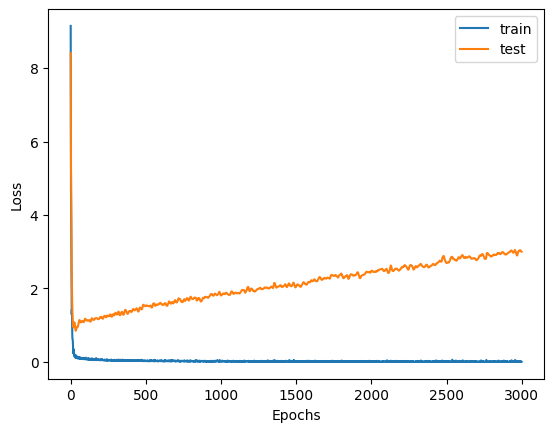

In [103]:
training_fn(data, train_labels, test_labels, model1, optimizer1, loss_fn)

  0%|          | 10/3000 [00:00<00:33, 89.30it/s]

Epoch: 0		Train loss: 4.1561784744262695		Test loss: 4.0401506423950195


 34%|███▍      | 1016/3000 [00:11<00:24, 81.80it/s]

Epoch: 1000		Train loss: 0.09163247048854828		Test loss: 1.3246514797210693


 67%|██████▋   | 2016/3000 [00:23<00:10, 90.02it/s]

Epoch: 2000		Train loss: 0.017878204584121704		Test loss: 2.4335412979125977


100%|██████████| 3000/3000 [00:34<00:00, 86.05it/s]


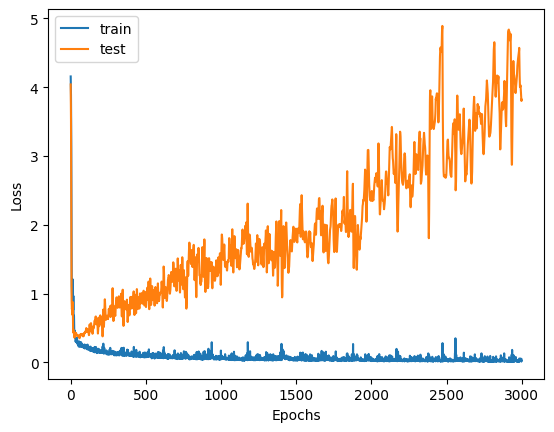

In [104]:
training_fn(data, train_labels, test_labels, model2, optimizer2, loss_fn)

Quoting from [Graph Neural Networks in Action - Keita Broadwater](https://www.manning.com/books/graph-neural-networks-in-action):

>  A graph embedding is a low-dimensional vector representation of a graph, node, or edge that retains essential structural and relational information. Much like reducing a high-resolution image to a compact feature vector, embeddings condense the graph's complexity while preserving its distinguishing characteristics.

<br>

> Transductive embedding methods learn representations for a fixed set of nodes in a single, static graph:
> - These methods directly optimize individual embeddings for each node.
> - The entire graph structure must be available during training.
> - These methods can’t naturally generalize to unseen nodes or graphs.
> - Adding new nodes requires retraining the entire model.
> - Examples include DeepWalk, N2V, and matrix factorization approaches.
> - Transductive methods allow us to reduce the scope of the prediction problem.
> - For transduction, we're only concerned with the data we're presented with.
> - These methods are computationally costly for large amounts of data.

<br>

> Inductive embedding methods learn a function to generate embeddings, allowing generalization to unseen nodes and even entirely new graphs:
> - These methods learn to aggregate and transform node features and local graph structure.
> - These methods can generate embeddings for previously unseen nodes without retraining.
> - Node attributes or structural features are often used.
> - These methods are more flexible and scalable for dynamic or expanding graphs.
> - Examples include GraphSAGE, GCNs, and graph attention networks (GATs).

<br>

> Message Passing:
> - The features, either node or edge data, are the messages, and the number of hops is the number of times we pass a message. Both of these are controlled by the layers of a GNN. The number of hidden layers is the number of hops that we'll be sending messages.
> - In a GNN, this information comprises the messages that we send over our graph. For each message-passing step, the vertex in our neural network collects information from nodes or edges one hop away. So, if we want our node representations to take account of nodes from three hops away from each node, we need three hidden message-passing layers.
> - In each step in the message-passing layer of our GNNs, we'll be passing information from nodes to another node one hop away. Importantly, a neural network then takes the data from the one-hop neighbors and applies a nonlinear transformation. This is the beauty of GNNs; we're applying many small neural networks at the level of individual nodes and/or edges to build embeddings of the graph features.

Data(edge_index=[2, 882], value=[105], num_nodes=105, x=[105, 64], train_mask=[105], test_mask=[105])